In [1]:
import os
import json
import pandas as pd
import numpy as np
import tqdm
import scipy.sparse as sp

from pprint import pprint

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import swifter

sns.set_style('whitegrid')

In [3]:
from datetime import timedelta
from IPython.display import Image

import matplotlib
matplotlib.rc('figure', figsize=(10, 5))

In [4]:
DATA_PATH = '..\\data'

### What to watch

In [5]:
with open(os.path.join(DATA_PATH, 'catalogue.json'), 'r') as f:
    catalogue = json.load(f)
    
catalogue = {int(k): v for k, v in catalogue.items()}
catalogue_df = pd.DataFrame.from_dict(catalogue).transpose()
catalogue_df['element_uid'] = catalogue_df.index
catalogue_df.reset_index(drop=True, inplace=True)

In [6]:
catalogue_df.head(5)

,type,availability,duration,feature_1,feature_2,feature_3,feature_4,feature_5,attributes,element_uid
0,movie,"[purchase, rent, subscription]",140,1.65722e+06,0.75361,39,1.11941,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1983
1,movie,"[purchase, rent, subscription]",110,3.55652e+07,0.766254,41,1.1386,0.654707,"[1, 26, 27, 28, 29, 7, 30, 31, 32, 10, 14, 15,...",3783
2,movie,"[purchase, rent, subscription]",90,1.32707e+07,0.765425,27,1.13181,0.592716,"[1, 38, 39, 40, 7, 41, 42, 43, 14, 15, 17, 18,...",5208
3,movie,"[purchase, rent, subscription]",120,2.17499e+07,0.757874,26,1.13353,0.654707,"[1, 47, 48, 49, 50, 51, 52, 53, 32, 42, 54, 14...",9744
4,movie,"[purchase, rent]",110,9.21296e+06,0.759566,7,1.11013,0.654707,"[1, 59, 60, 61, 62, 7, 52, 63, 10, 42, 54, 17,...",1912


Possibly:
- feature_1: when the item was added to the database
- feature_2: processed rating
- feature_3: the number of reviews

### How people watch - Transactions

In [20]:
%%time
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

Wall time: 6.71 s


In [21]:
transactions = transactions.merge(catalogue_df[['type', 'duration', 'element_uid']], how='left', on='element_uid')

In [22]:
transactions.head(3)

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer,type,duration
0,3336,5177,S,4.430518e+07,4282,0,50,movie,90
1,481,593316,S,4.430518e+07,2989,0,11,movie,50
2,4128,262355,S,4.430518e+07,833,0,50,movie,100


Important moment: <br>
The user is considered to have consumed the content if they:
1. Bought it or rented it
2. Watched more than half of the movie by subscription
3. Watched more than a third of the series by subscription

Here we don't have the number of episodes for series and multipart movies. We can't estimate, did the user consume that kind of items. That's why I remove them from the dataset. 

In [23]:
transactions = transactions[~transactions['type'].isin(['series', 'multipart_movie'])]

By default we have watched_time in seconds, but the duration in minutes. Let's calculate watched_time_minutes

In [24]:
transactions['watched_time_minutes'] = transactions['watched_time'].swifter.apply(lambda x: int(x/60))

<AxesSubplot:xlabel='watched_time_minutes', ylabel='Density'>

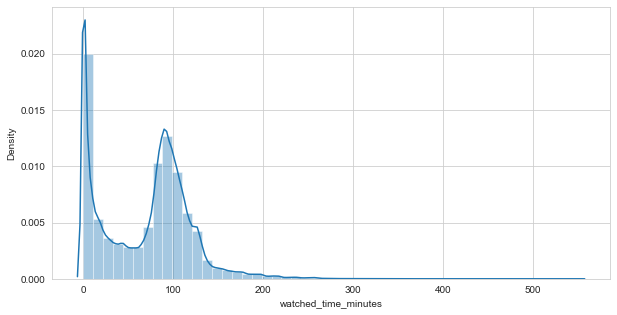

In [108]:
sns.distplot(transactions['watched_time_minutes'])

<AxesSubplot:xlabel='watched_time_minutes'>

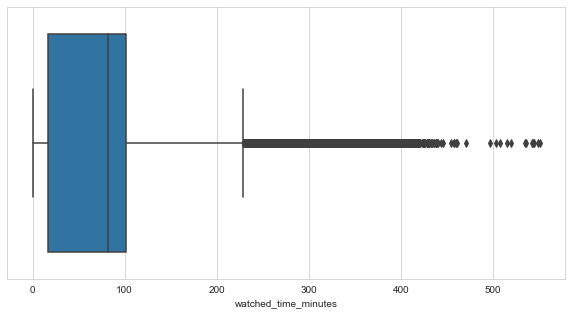

In [109]:
sns.boxplot(transactions['watched_time_minutes'])

In [25]:
transactions['watched_time_minutes'].describe()

count    8.447928e+06
mean     7.958585e+01
std      1.092484e+02
min      0.000000e+00
25%      1.800000e+01
50%      8.300000e+01
75%      1.050000e+02
max      5.096400e+04
Name: watched_time_minutes, dtype: float64

Let's calculate watched ratio based on duration and watched_time_minutes

<b>Note</b>: duration is rounded to tens and could be zero

Let's check how many very short movies in the catalogue

<AxesSubplot:>

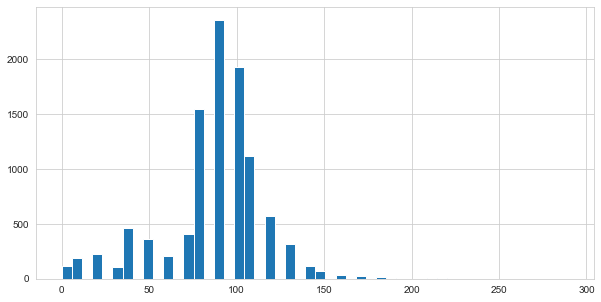

In [13]:
catalogue_df['duration'].hist(bins=50)

In [26]:
zero_movies_ratio = catalogue_df[catalogue_df['duration'] == 0].shape[0]/catalogue_df.shape[0]
print('Total number of movies = {0}'.format(catalogue_df.shape[0]))
print('The number of zero-duration movies = {0}'.format(catalogue_df[catalogue_df['duration'] == 0].shape[0]))
print('The ratio of zero-duration movies (in percent) = {0}%'.format(round(zero_movies_ratio*100, 2)))

Total number of movies = 10200
The number of zero-duration movies = 114
The ratio of zero-duration movies (in percent) = 1.12%


In [27]:
zero_duration_movies = catalogue_df[catalogue_df['duration'] == 0]['element_uid']

In [28]:
transactions = transactions[~transactions['element_uid'].isin(zero_duration_movies)]

In [29]:
transactions['duration'] = transactions['duration'].astype('int32')

In [30]:
transactions['watched_ratio'] = transactions['watched_time_minutes']/transactions['duration']

In [31]:
transactions['watched_ratio'].describe()

count    8.444769e+06
mean     7.918364e-01
std      1.079774e+00
min      0.000000e+00
25%      2.090909e-01
50%      9.100000e-01
75%      1.007692e+00
max      5.096400e+02
Name: watched_ratio, dtype: float64

In [32]:
transactions[transactions['watched_ratio'] > 4]

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer,type,duration,watched_time_minutes,watched_ratio
348,9472,276079,S,4.430509e+07,32079,0,50,movie,110,534,4.854545
352,3245,592120,S,4.430508e+07,31344,0,11,movie,100,522,5.220000
511,2218,314462,S,4.430505e+07,27559,0,50,movie,100,459,4.590000
920,8501,141969,S,4.430495e+07,29200,0,11,movie,110,486,4.418182
1143,747,98652,S,4.430490e+07,56758,0,99,movie,120,945,7.875000
...,...,...,...,...,...,...,...,...,...,...,...
9641572,3336,147771,P,4.173097e+07,28695,0,11,movie,90,478,5.311111
9642167,1354,468386,P,4.173082e+07,36404,0,11,movie,100,606,6.060000
9642443,1875,130970,P,4.173076e+07,51566,0,99,movie,120,859,7.158333
9642711,6377,25473,S,4.173069e+07,67106,0,85,movie,110,1118,10.163636


Maybe it depends on consumption_mode?

In [33]:
transactions.groupby(['consumption_mode'])['watched_ratio'].agg(['count', 'median', 'min', 'max'])

,count,median,min,max
consumption_mode,,,,
P,847756,0.977778,0.0,245.275
R,472377,0.970000,0.0,38.200
S,7124636,0.880000,0.0,509.640


What is the ratio of transactions which have watched_ratio more than 2

In [34]:
print('{0}%'.format(round(transactions[transactions['watched_ratio'] > 2].shape[0]/transactions.shape[0], 2)*100))

3.0%


In [35]:
transactions = transactions[transactions['watched_ratio'] <= 2]

<AxesSubplot:xlabel='watched_ratio'>

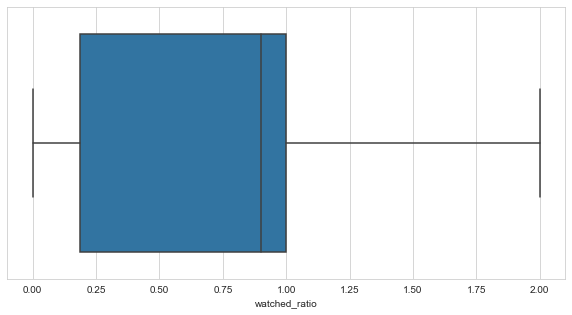

In [36]:
sns.boxplot(transactions['watched_ratio'])

Let's label transactions in respect with rule, how the user could be considered to have consumed the content

In [37]:
def set_target(row):
    if row['consumption_mode'] == 'S':
        if row['watched_time_minutes'] < row['duration']*0.5:
            return 0
        else:
            return 1
    else:
        return 1

In [38]:
transactions['target'] = transactions.apply(set_target, axis=1)

In [39]:
print('The ratio of consumed items = {0}%'.format(round(transactions[transactions['target'] == 1].shape[0]/transactions.shape[0], 2)*100))

The ratio of consumed items = 67.0%


Let's explore timestamps of transactions

If we assume that we have the number of seconds from some starting point

In [40]:
(transactions['ts'].max()-transactions['ts'].min())/(60*60*24)

29.798006361554965

We have close to a month of observations. This is kind of weird because the organizers of the competition told that they gave us data about 60 days of observations. But from that moment the dataset could be fixed.

We can try to set some pretty form of timestamps using <i>datetime.utcfromtimestamp()</i> method

In [41]:
transactions['real_ts'] = transactions['ts'].swifter.apply(lambda ts: datetime.utcfromtimestamp(ts + 1500000000).replace(microsecond=0))

It could be convinient to explore the nature of the process behind the dataset using the usual or more familiar representation of time

<AxesSubplot:xlabel='real_ts'>

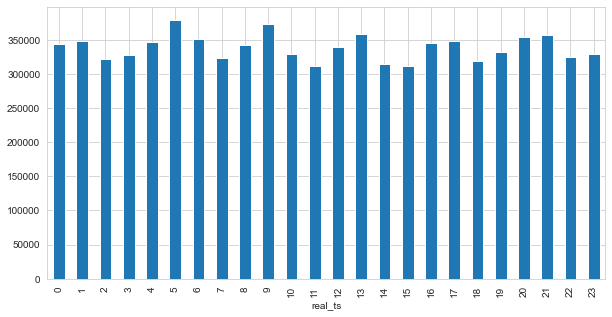

In [44]:
transactions.groupby([transactions.real_ts.dt.hour]).size().plot.bar()

There is an assumption that if the server is located somewhere in one place, and the service operates in all time zones that exist in Russia, so transactions are distributed uniformly

But maybe it means that we chose wrong approach of time convertation

Anyway, let's assume that it wac correct and try to extract more insights from ts column

In [45]:
transactions['real_ts'].describe()

count                 8155287
unique                2091525
top       2018-11-24 09:55:39
freq                      300
first     2018-11-09 02:30:33
last      2018-12-08 21:39:41
Name: real_ts, dtype: object

2018-11-09 was Friday <br>
2018-12-08 was Saturday

Let's group transactions by week, starts from Thursday. Actually, it could be very convinient because Thursday usually is a premier weekday

In [46]:
transactions.groupby([pd.Grouper(key='real_ts', freq='W-THU')]).size()

real_ts
2018-11-15    1732532
2018-11-22    1647925
2018-11-29    2096922
2018-12-06    2079451
2018-12-13     598457
Freq: W-THU, dtype: int64

<AxesSubplot:xlabel='real_ts'>

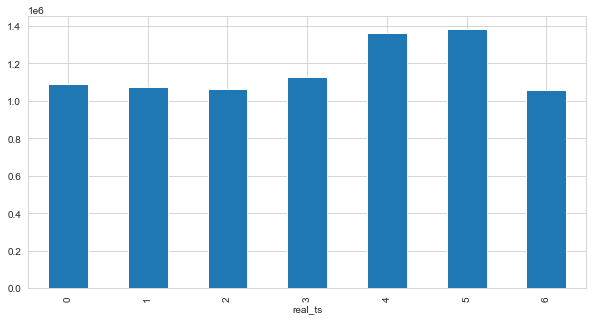

In [60]:
transactions.groupby([transactions.real_ts.dt.dayofweek]).size().plot.bar()

It looks more likelihood

In [ ]:
fig, axes = plt.subplots(1, 7, sharey=True, figsize=(25, 3))

In [76]:
for weekday, data in transactions.groupby([transactions.real_ts.dt.dayofweek]):
    print(weekday)
    data.groupby([transactions.real_ts.dt.hour]).size().plot.bar(ax=axes[weekday])

0
1
2
3
4
5
6


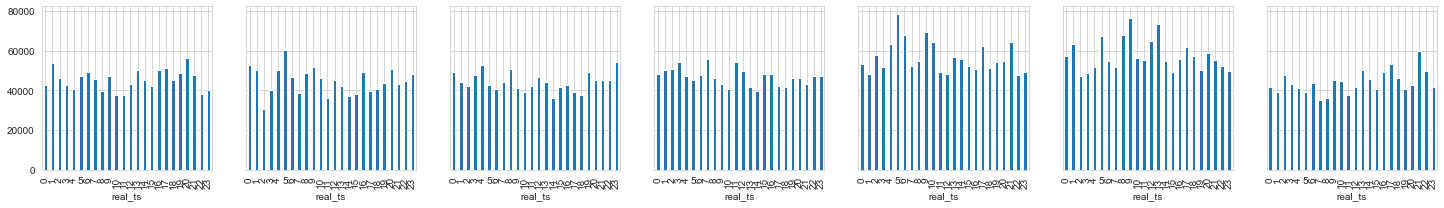

In [77]:
fig

Let's estimate new users inflow

In [47]:
counter = 0
users_sets = {}
while 30 > counter*7:
    mask = (transactions['real_ts'] > transactions['real_ts'].min() + timedelta(days=counter*7)) & (transactions['real_ts'] <= transactions['real_ts'].min() + timedelta(days=(counter+1)*7))
    week_slice = transactions.loc[mask]
    week_users = week_slice['user_uid'].unique()
    users_sets[str(counter+1)] = week_users
    counter += 1

In [48]:
for key, value in users_sets.items():
    print('for week {0} were {1} unique users'.format(key, len(value)))

for week 1 were 235032 unique users
for week 2 were 223799 unique users
for week 3 were 264882 unique users
for week 4 were 271190 unique users
for week 5 were 127286 unique users


In [53]:
base_users = []
for key, value in users_sets.items():
    if key == '1':
        base_users.extend(value)
        continue
    else:
        total_users_number = len(value)
        intersection = list(set(base_users) & set(value))
        ratio = (total_users_number - len(intersection))/total_users_number
        new_users = np.setdiff1d(value, base_users)
        base_users.extend(value)
        
        print('for week {0} was {1}% new users ({2}/{3})'.format(key, round(ratio*100, 2), len(new_users), total_users_number))

for week 2 was 39.12% new users (87559/223799)
for week 3 was 32.06% new users (84911/264882)
for week 4 was 27.57% new users (74755/271190)
for week 5 was 11.29% new users (14367/127286)


Now let's do the same estimation for items

In [54]:
counter = 0
items_sets = {}
while 30 > counter*7:
    mask = (transactions['real_ts'] > transactions['real_ts'].min() + timedelta(days=counter*7)) & (transactions['real_ts'] <= transactions['real_ts'].min() + timedelta(days=(counter+1)*7))
    week_slice = transactions.loc[mask]
    week_items = week_slice['element_uid'].unique()
    items_sets[str(counter+1)] = week_items
    counter += 1

In [55]:
for key, value in items_sets.items():
    print('for week {0} were {1} unique items'.format(key, len(value)))

for week 1 were 6635 unique items
for week 2 were 6508 unique items
for week 3 were 6653 unique items
for week 4 were 6780 unique items
for week 5 were 6091 unique items


In [57]:
base_items = []
for key, value in items_sets.items():
    if key == '1':
        base_items.extend(value)
        continue
    else:
        total_items_number = len(value)
        intersection = list(set(base_items) & set(value))
        ratio = (-len(intersection) + total_items_number)/total_items_number
        new_items = np.setdiff1d(value, base_items)
        base_items.extend(value)
        
        print('for week {0} was {1}% new items ({2}/{3})'.format(key, round(ratio*100, 2), len(new_items), total_items_number))

for week 2 was 4.15% new items (270/6508)
for week 3 was 2.92% new items (194/6653)
for week 4 was 2.64% new items (179/6780)
for week 5 was 0.25% new items (15/6091)


Let's see how many transactions users spend for 1 item

In [58]:
transactions.groupby(['user_uid', 'element_uid']).size().value_counts()

1    8155287
dtype: int64

### Rating

In [81]:
%%time
ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'ratings.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64,
        'rating': np.uint8
    }
)

Wall time: 246 ms


In [82]:
ratings.head(3)

,user_uid,element_uid,rating,ts
0,571252,1364,10,4.430517e+07
1,63140,3037,10,4.430514e+07
2,443817,4363,8,4.430514e+07


Let's update form of ts

In [83]:
ratings['rating_time'] = ratings['ts'].apply(lambda ts: datetime.utcfromtimestamp(ts + 1500000000).replace(microsecond=0))

Let's merge transactions with ratings

In [84]:
transactions = transactions.merge(ratings[['user_uid', 'element_uid', 'rating', 'rating_time']],  how='left', left_on=['user_uid', 'element_uid'], right_on = ['user_uid', 'element_uid'])

In [85]:
transactions[['user_uid', 'rating', 'rating_time']].info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8155287 entries, 0 to 8155286
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   user_uid     8155287 non-null  uint32        
 1   rating       316244 non-null   float64       
 2   rating_time  316244 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), uint32(1)
memory usage: 217.8 MB


Check is there dependency between facts to be consumed and to be rated

In [93]:
transactions['rated'] = ~transactions['rating'].isnull()*1

In [94]:
transactions['rated'].value_counts()

0    7839043
1     316244
Name: rated, dtype: int64

In [98]:
pd.crosstab(transactions['rated'], transactions['target'])

target,0,1
rated,,
0,2682278,5156765
1,10708,305536


In [99]:
from scipy.stats import chi2_contingency

In [104]:
chi2_contingency(pd.crosstab(transactions['rated'], transactions['target']))

(130642.05721926835,
 0.0,
 1,
 array([[2588557.95662348, 5250485.04337652],
        [ 104428.04337652,  211815.95662348]]))

It means, that the chi2 distance from expected distribution to observed data is 130642.06 <br>
And the probability to achive that or even more distance value is 0.0 (p-value) if we hypothesised that the consumption does not affect the fact of setting the rating <br> 
So we can say, that it is more likely that user who cunsumed the item will set rating to this item

Now let's check closer dependency but between rating and watched ratio

<AxesSubplot:xlabel='rated', ylabel='watched_ratio'>

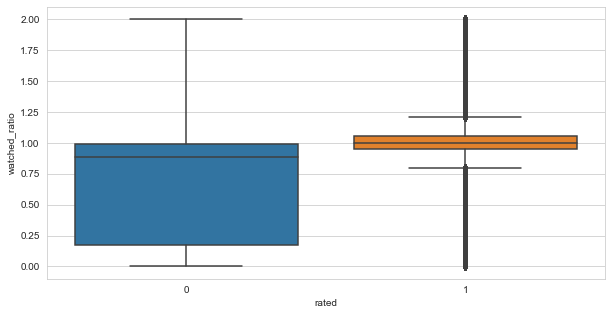

In [107]:
sns.boxplot(data=transactions, x='rated', y='watched_ratio')